# Predviđanje Alzheimerove bolesti u ranim fazama korištenjem modela strojnog učenja

## 1. Uvod
Projekt se u prvoj fazi bavi replikacijom rezultata [znanstvenog članka](https://www.frontiersin.org/articles/10.3389/fpubh.2022.853294/full).

Korišteni skup podataka nalazi se [ovdje](https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers).

### Problematika

Alzheimerova bolest je neurodegenerativna bolest koja obično počinje polako i postupno se pogoršava. Ona je uzrok 60-70% slučajeva demencije. Najčešći rani simptom je teškoća u pamćenju nedavnih događaja. Kako bolest napreduje, simptomi mogu uključivati probleme s govorom, dezorijentaciju, promjene raspoloženja, gubitak motivacije i probleme s ponašanjem.

### Opis značajki

* Group - dijagnoza

#### MRI značajke
* ID - Identifikacijski broj
* M/F - Spol (M = muško, F = žensko)
* Hand - Dominantna ruka
* Age - Dob u godinama
* EDUC - Broj godina obrazovanja
* SES - Socijalno-ekonomski status
* MMSE - Mini Mental State Examination (test za procjenu kognitivnih funkcija)
* CDR - Clinical Dementia Rating (klinička ocjena demencije)
* eTIV - Procijenjeni ukupni intrakranijalni volumen
* nWBV - Normalizirani volumen cijelog mozga
* ASF - Faktor skaliranja atlasa
* Delay - Kašnjenje

## 2. Učitavanje i analiza podatkovnog skupa

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('Dataset.csv')
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [214]:
df_without_duplicate_subject_id = df.drop_duplicates(subset='Subject ID')
df_2 = df_without_duplicate_subject_id

unique_hand = df_2['Hand'].unique()
unique_age = df_2['Age'].unique()

df.shape, df_2.shape[0], unique_hand, unique_age.min(), unique_age.max()

((373, 15), 150, array(['R'], dtype=object), 60, 96)

Podatkovni skup ima 373 retka i 15 stupaca. Sastoji se od MRI podataka za 150 različitih ispitanika u dobi od 60 do 96 godina.
Svi ispitanici su dešnjaci.

### Tipovi podataka

Tipovi podataka koji se koriste su: **int64**, **object** i **float64**.

Stupci **Subject ID**, **MRI ID**, **M/F** i **Hand** su tipa object, a ostali stupci su cijeli ili realni brojevi.

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


([<matplotlib.patches.Wedge at 0x2180317b1d0>,
 [Text(1.0530514468883778, 0.3179349779535027, 'Converted'),
  Text(-0.38342928809191557, 1.0310101750386982, 'Demented'),
  Text(0.06906960848527893, -1.0978293989430645, 'Nondemented')],
 [Text(0.5743916983027514, 0.17341907888372873, '9.33%'),
  Text(-0.20914324805013573, 0.5623691863847443, '42.67%'),
  Text(0.03767433190106123, -0.598816035787126, '48.00%')])

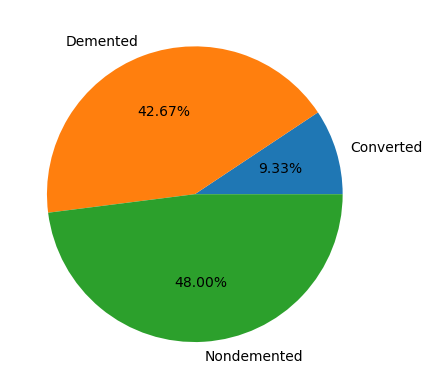

In [216]:
group = df_2.groupby('Group').count().loc[:, 'Subject ID'].values
group_name = df_2.groupby('Group').count().index.values
plt.pie(group, labels=group_name, autopct='%1.2f%%')

Stupac **Group** čine tri klase: Demented, Nondemented i Converted.

64 ispitanika je klasificirano u klasu Demented prilikom prvog posjeta i u toj klasi su ostali tijekom cijelog istraživanja. 72 ispitanika su nedementna (klasa Nondemented). 14 ispitanika je inicijalno u klasi Nondemented, ali su kasnije prebačeni u klasu Demented. Ti ispitanici pripadaju grupi Converted.

In [217]:
df = df.drop(['Hand', 'MRI ID'], axis=1)

### Nedostajuće vrijednosti

Identificirano je da stupci **SES** i **MMSE** sadrže nedostajuće vrijednosti. Nad tim vrijednostima izvršena je imputacija pomoću medijana grupiranog po vrijednostima stupca **EDUC**.

In [218]:
df.isna().any()

Subject ID    False
Group         False
Visit         False
MR Delay      False
M/F           False
Age           False
EDUC          False
SES            True
MMSE           True
CDR           False
eTIV          False
nWBV          False
ASF           False
dtype: bool

In [219]:
for i in ['SES', 'MMSE']:
    df[i].fillna(df.groupby('EDUC')[i].transform('median'), inplace=True)

### Vizualizacija i analiza podataka

C:\Users\least\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(15.3, 30.0)

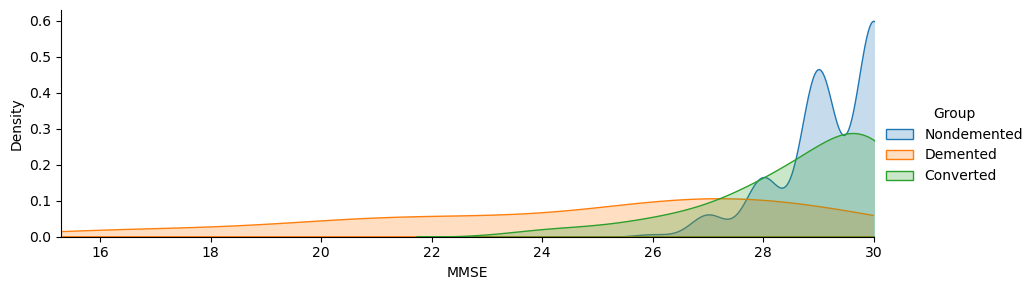

In [220]:
facet = sns.FacetGrid(df, hue="Group", aspect=3)
facet.map(sns.kdeplot,'MMSE', fill=True)
facet.set(xlim=(0, df['MMSE'].max()))
facet.add_legend()
plt.xlim(15.30)

Redefinirajmo kategoričku varijablu **Group** tako što ćemo vrijednosti prikazati pomoću 0 i 1 tako da 0 predstavlja klasu **Nondemented**, a 1 klasu **Demented**.

In [221]:
df['Group'] = df['Group'].replace(['Converted'], ['Demented'])
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0])
df.head()

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,0,1,0,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,0,2,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,1,1,0,M,75,12,3.0,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,1,2,560,M,76,12,3.0,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,1,3,1895,M,80,12,3.0,22.0,0.5,1698,0.701,1.034


C:\Users\least\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\least\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\least\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(0.6, 0.9)

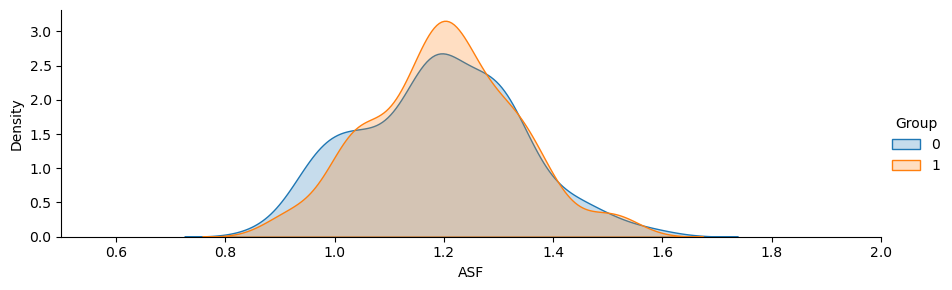

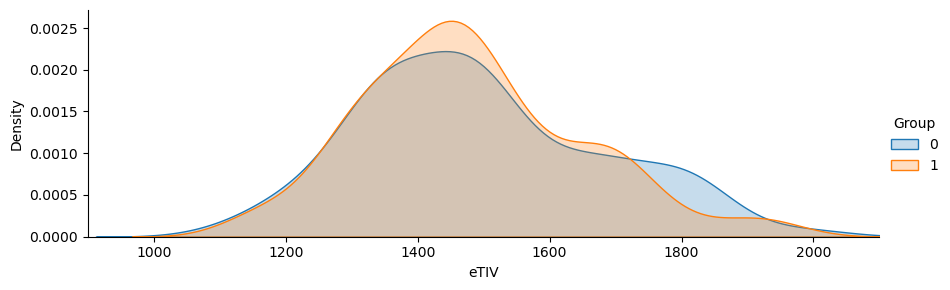

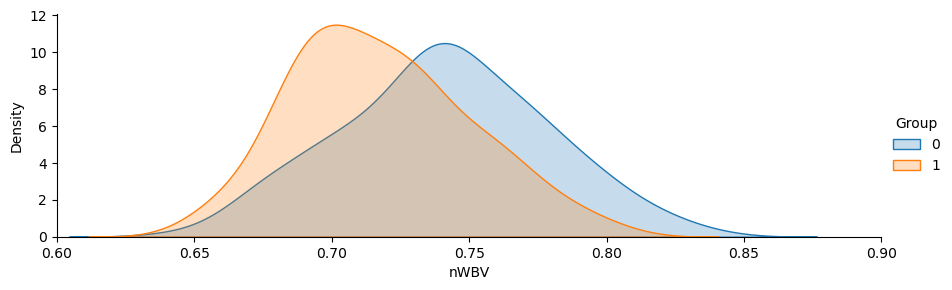

In [222]:
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'ASF',fill= True)
facet.set(xlim=(0, df['ASF'].max()))
facet.add_legend()
plt.xlim(0.5, 2)

facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'eTIV',fill= True)
facet.set(xlim=(0, df['eTIV'].max()))
facet.add_legend()
plt.xlim(900, 2100)

facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'nWBV',fill= True)
facet.set(xlim=(0, df['nWBV'].max()))
facet.add_legend()
plt.xlim(0.6,0.9)

C:\Users\least\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(0.0, 0.16)

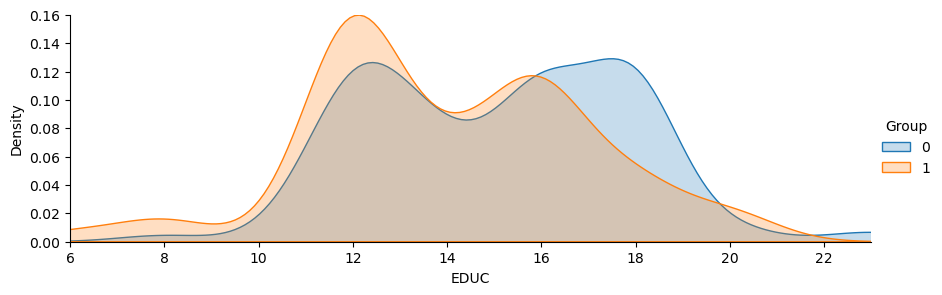

In [223]:
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'EDUC',fill= True)
facet.set(xlim=(df['EDUC'].min(), df['EDUC'].max()))
facet.add_legend()
plt.ylim(0, 0.16)

C:\Users\least\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(50.0, 100.0)

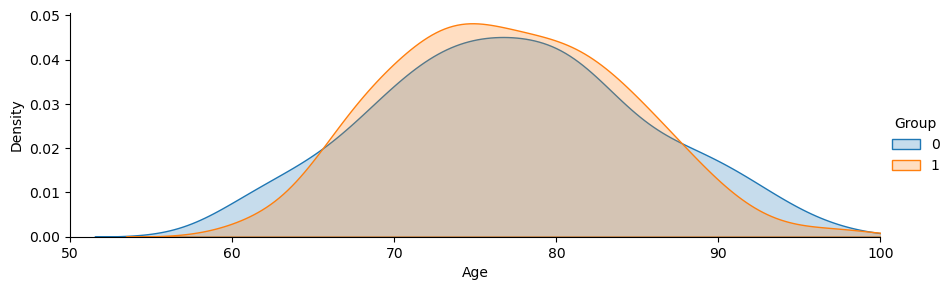

In [224]:
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'Age',fill= True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()
plt.xlim(50,100)

Redefinirajmo kategoričku varijablu **M/F** tako što ćemo vrijednosti prikazati pomoću 0 i 1 tako da vrijedi **M = 1** i **F = 0**.

In [225]:
df['M/F'] = df['M/F'].replace(['M','F'], [1,0])
df_2 = df.drop_duplicates(subset='Subject ID')

In [226]:
def bar_chart(feature):
    demented = df_2[df_2['Group']==1][feature].value_counts()
    nondemented = df_2[df_2['Group']==0][feature].value_counts()
    df_bar = pd.DataFrame([demented, nondemented])
    df_bar.index = ['Demented','Nondemented']
    df_bar.plot(kind='bar',stacked=True)

Text(0.5, 1.0, 'Gender and Demented rate')

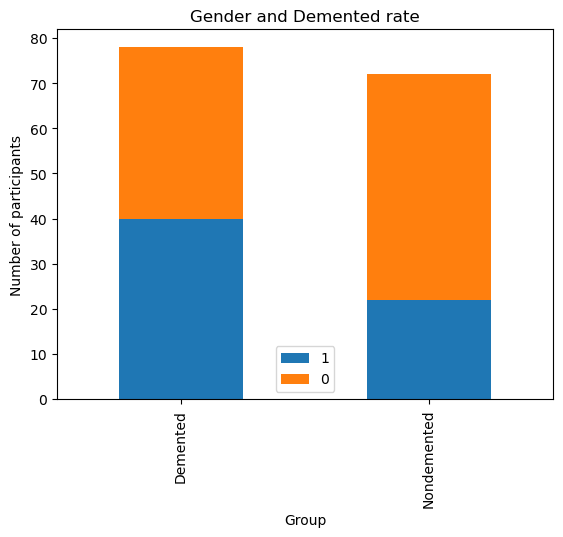

In [227]:
bar_chart('M/F')
plt.xlabel('Group')
plt.ylabel('Number of participants')
plt.legend()
plt.title('Gender and Demented rate')

#### Histogram značajki

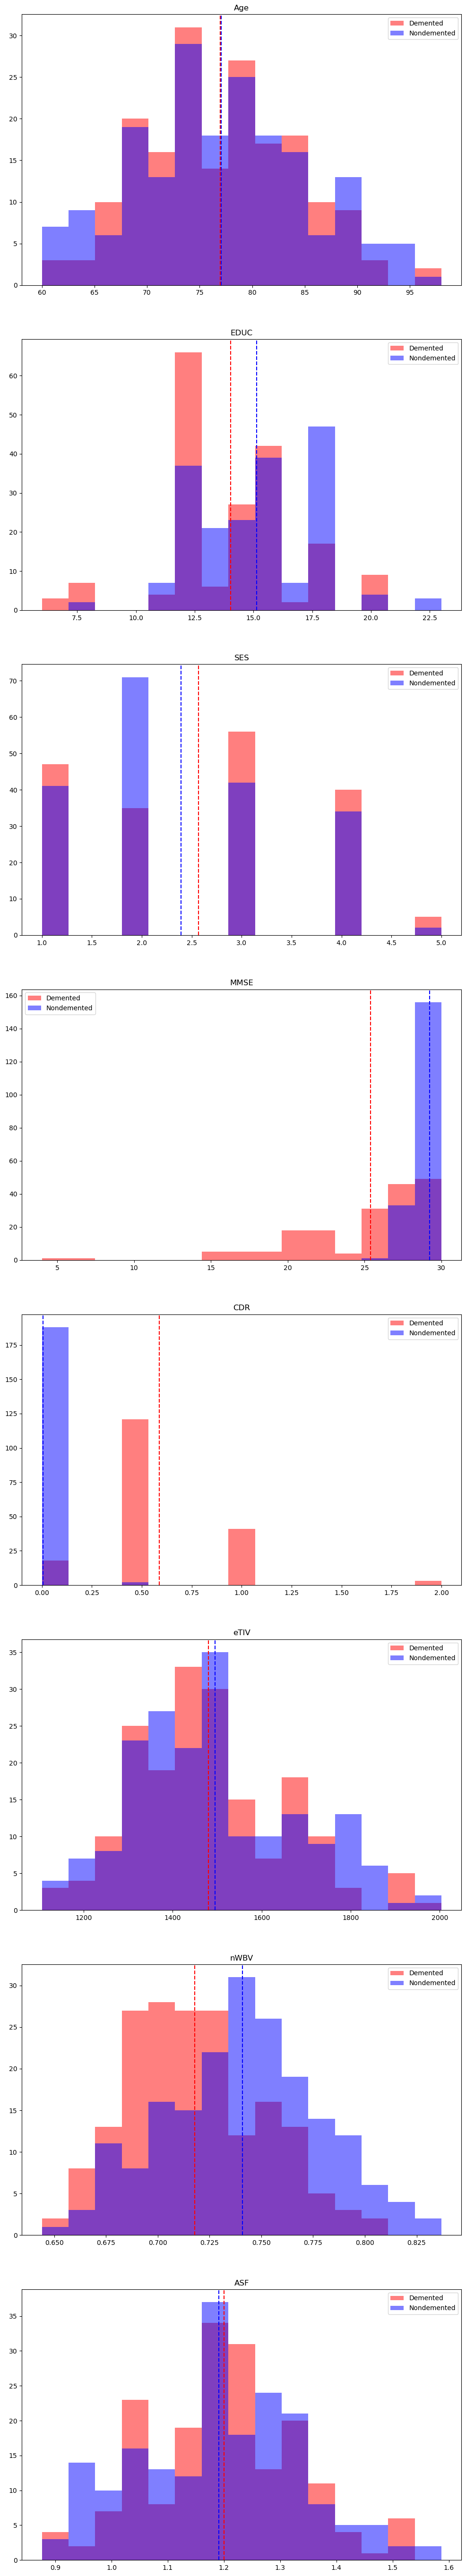

In [252]:
def plot_feature_by_group(ax, feature_name):
    feature_min = df[feature_name].min()
    feature_max = df[feature_name].max()
    ax.hist(df.loc[df['Group']==1, feature_name], bins=15, alpha=0.5, color='r', label='Demented', range=(feature_min, feature_max))
    ax.hist(df.loc[df['Group']==0, feature_name], bins=15, alpha=0.5, color='b', label='Nondemented', range=(feature_min, feature_max))
    ax.axvline(df.loc[df['Group']==1, feature_name].mean(), color='r', linestyle='dashed')
    ax.axvline(df.loc[df['Group']==0, feature_name].mean(), color='b', linestyle='dashed')
    ax.set_title(feature_name)
    ax.legend(loc='best')

fig, ax = plt.subplots(8, 1, figsize=(12, 70))
for i, column_name in enumerate(df.columns[5:]):
    plot_feature_by_group(ax[i], column_name)

#### Boxplot značajki

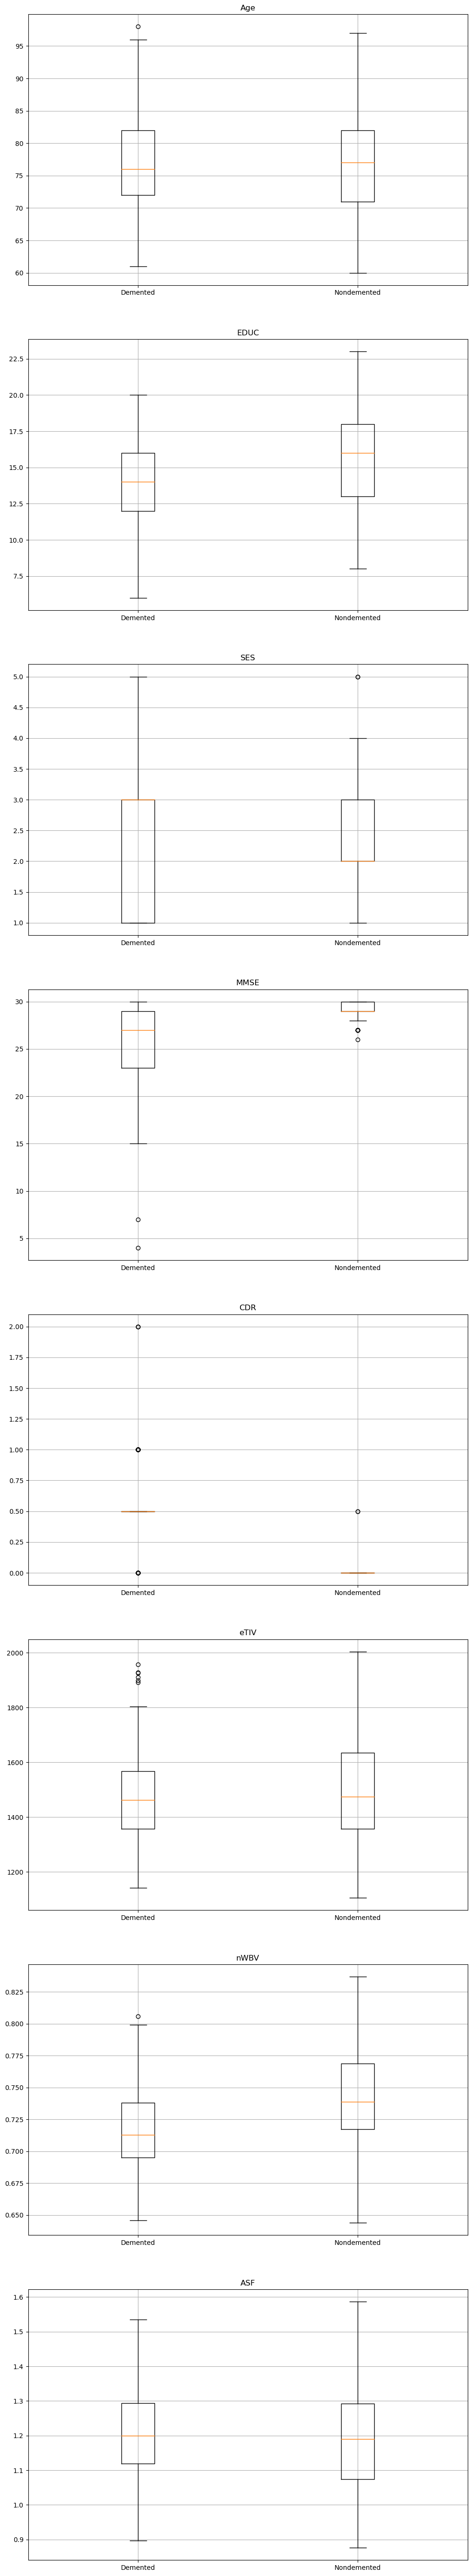

In [254]:
def boxplot_feature_by_group(ax, feature_name):
    boxplot_data = [df.loc[df['Group']==1, feature_name], df.loc[df['Group']==0, feature_name]]
    ax.boxplot(boxplot_data)
    ax.set_xticks([1, 2], ['Demented', 'Nondemented'])
    ax.set_title(feature_name)
    ax.grid()

fig, ax = plt.subplots(8, 1, figsize=(12, 70))
for i, column_name in enumerate(df.columns[5:]):
    boxplot_feature_by_group(ax[i], column_name)

#### Korelacijska matrica

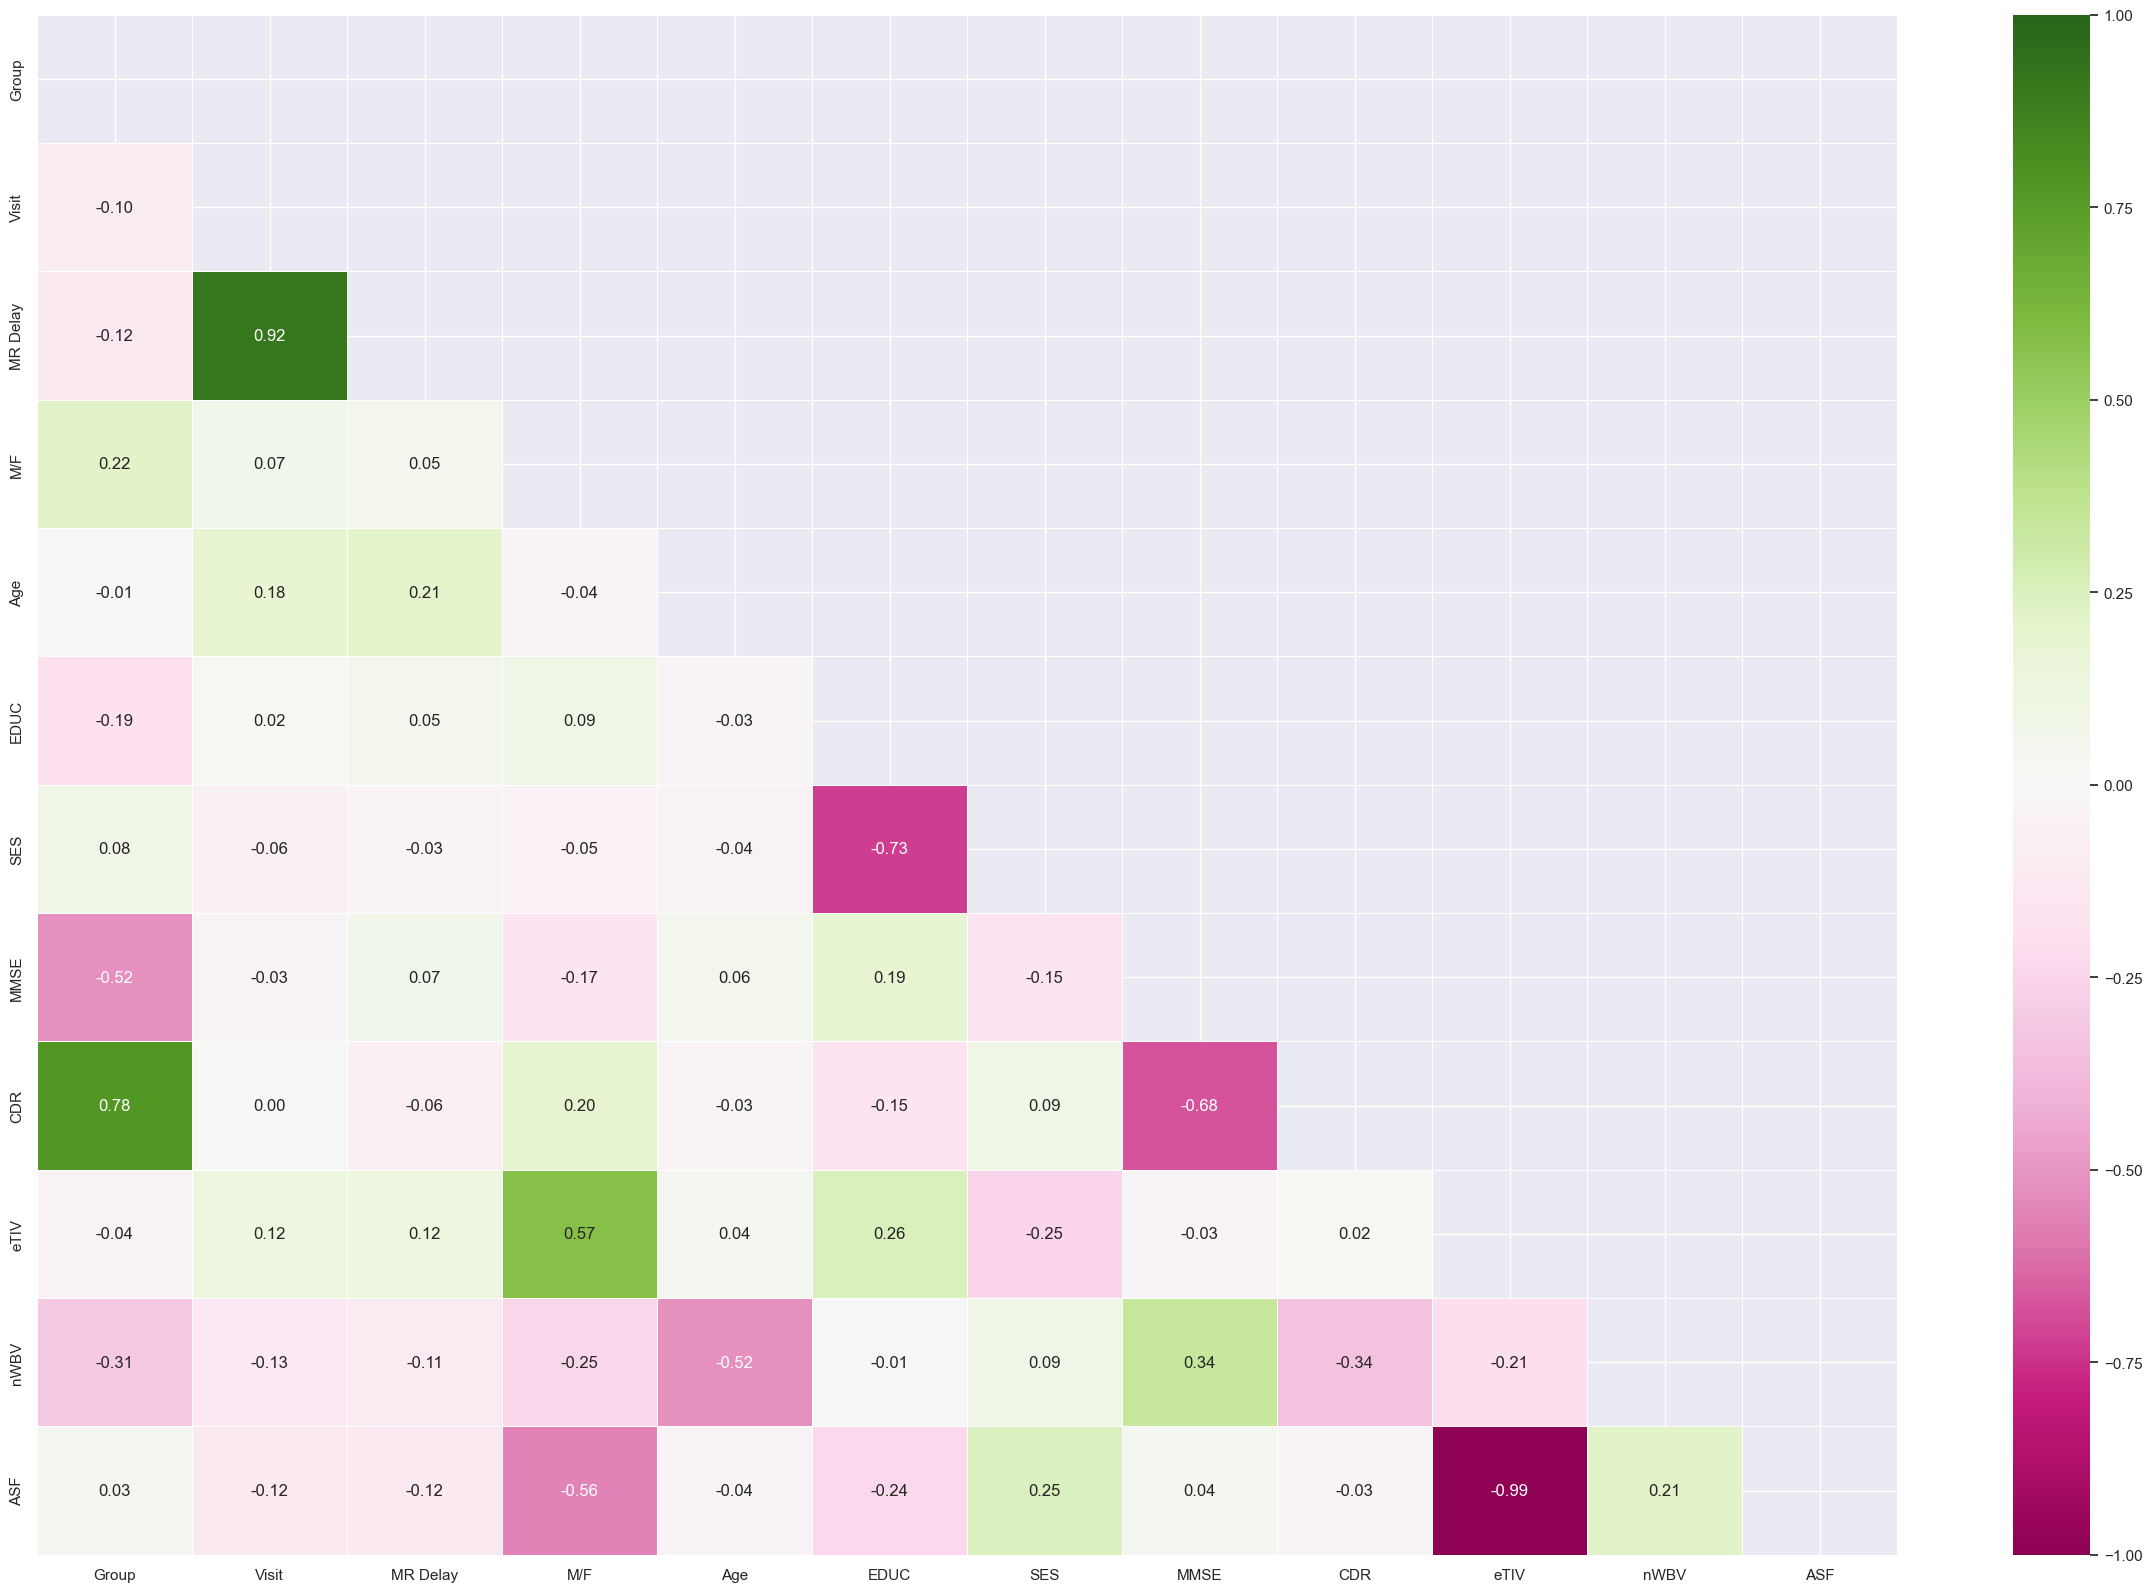

In [260]:
df_corr = df.drop(['Subject ID'], axis=1)
sns.set(rc={'figure.figsize':(30,20)})
mask = np.triu(np.ones((12,12)))
sns.heatmap(df_corr.corr(), mask=mask, annot=True, fmt=".2f", cmap="PiYG", linewidths=.5, vmin=-1.0, vmax=1.0)
plt.show()

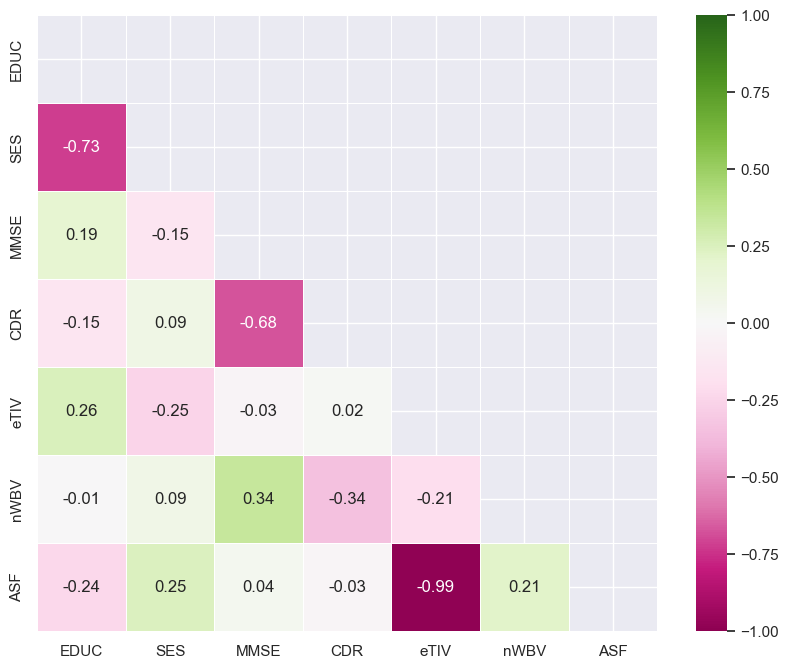

In [270]:
sns.set(rc={'figure.figsize':(10,8)})
mask = np.triu(np.ones((7, 7)))
sns.heatmap(df.iloc[:, 6:].corr(), mask=mask, annot=True, fmt=".2f", cmap="PiYG", linewidths=.5, vmin=-1.0, vmax=1.0)
plt.show()

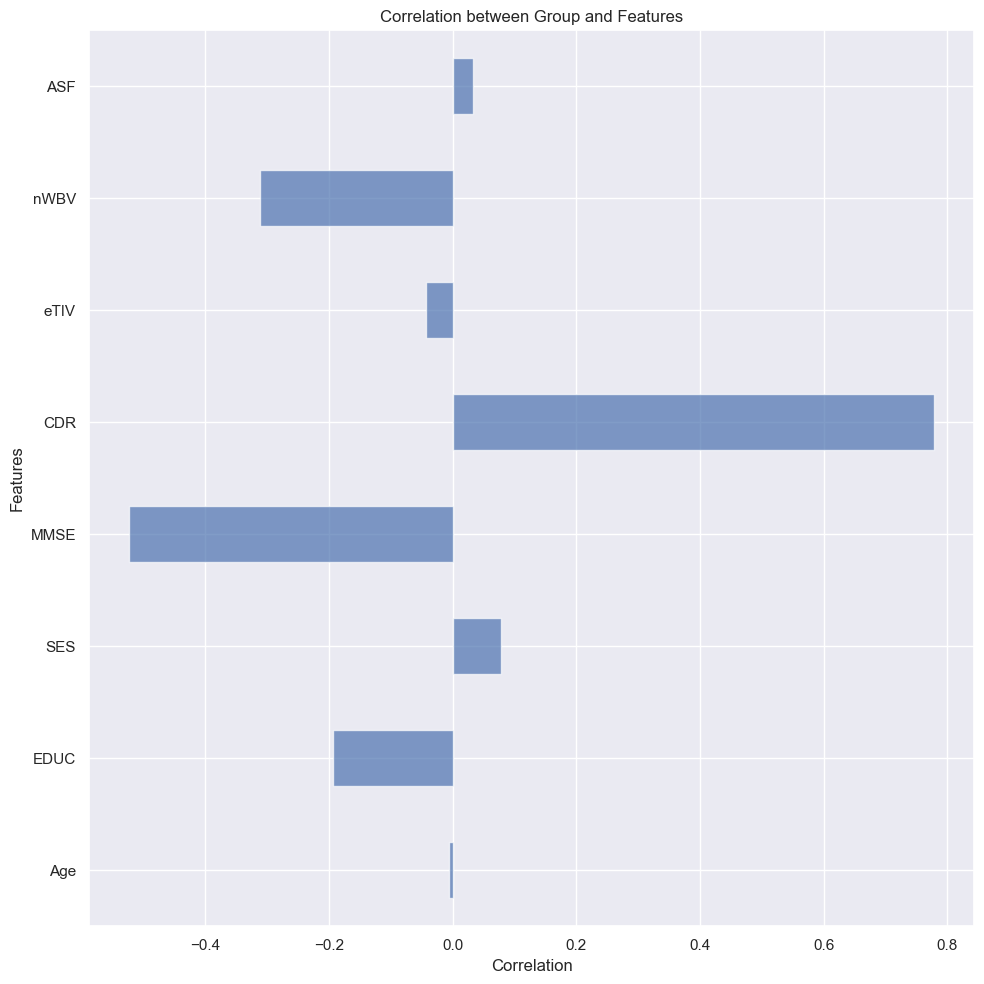

In [287]:
correlations = df.iloc[:, 5:].corrwith(df['Group']).transpose()

plt.figure(figsize=(10, 10))
correlations.plot(kind='barh', color='b', alpha=0.7)
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.title('Correlation between Group and Features')
plt.tight_layout()
plt.show()

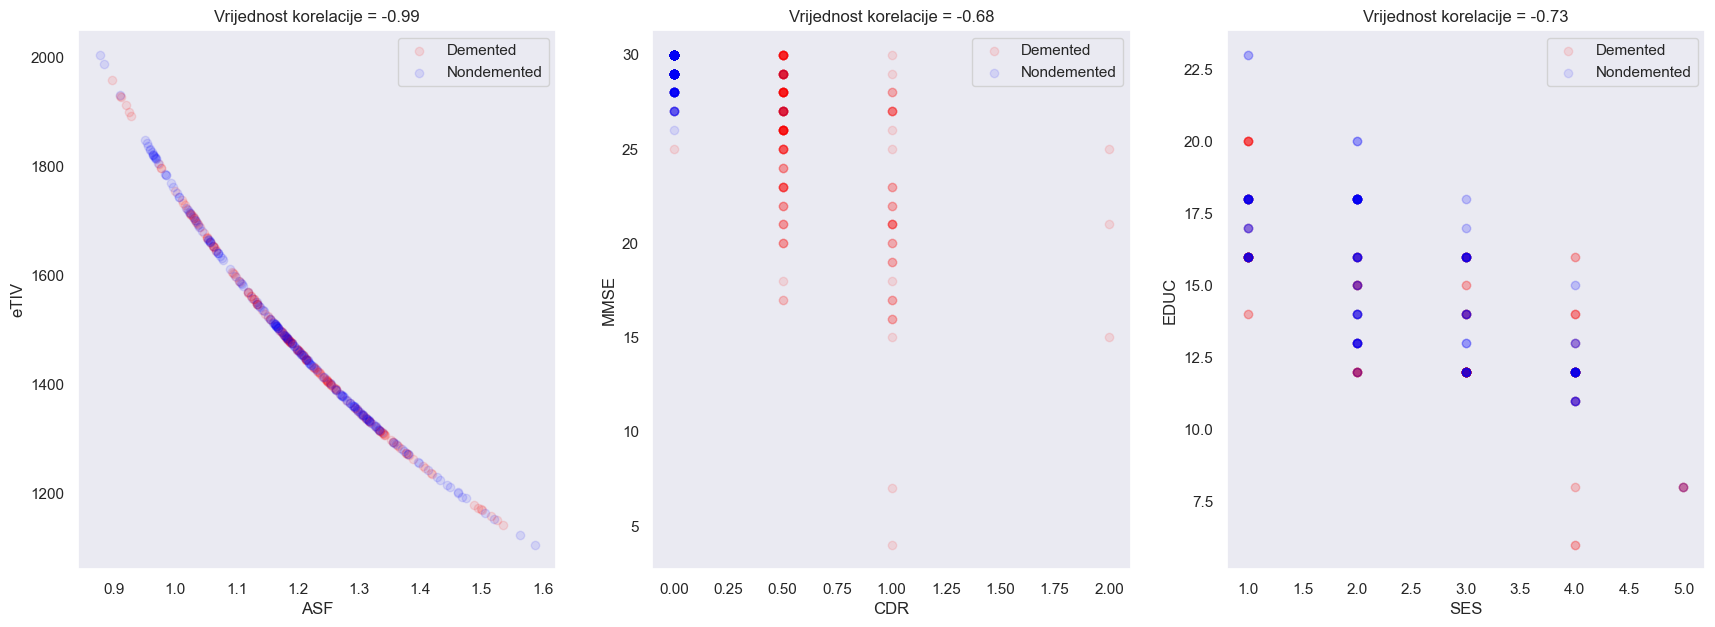

In [288]:
pos_data = df.loc[df['Group']==1, :]
neg_data = df.loc[df['Group']==0, :]


def plot_scatter_feature_by_diagnosis(ax, feature_name_1, feature_name_2, correlation_value):
    ax.scatter(pos_data.loc[:, feature_name_1], pos_data.loc[:, feature_name_2], alpha=0.1, color='red', label='Demented')
    ax.scatter(neg_data.loc[:, feature_name_1], neg_data.loc[:, feature_name_2], alpha=0.1, color='blue', label='Nondemented')
    ax.set_xlabel(feature_name_1)
    ax.set_ylabel(feature_name_2)
    ax.set_title(f'Vrijednost korelacije = {correlation_value}')
    ax.legend(loc='best')
    ax.grid()

fig, ax = plt.subplots(1, 3, figsize=(21, 7))
plot_scatter_feature_by_diagnosis(ax[0], 'ASF', 'eTIV', -0.99)
plot_scatter_feature_by_diagnosis(ax[1], 'CDR', 'MMSE', -0.68)
plot_scatter_feature_by_diagnosis(ax[2], 'SES', 'EDUC', -0.73)